In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install tensorflow --quiet

In [ ]:
# Import libraries for data manipulation and analysis
import pandas as pd
import numpy as np

# Import libraries for working with dates and times
import datetime as dt

# Import TensorFlow and Keras libraries for building and training neural networks
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
from keras.regularizers import l2

# Import scikit-learn library for various metrics and preprocessing tools
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import MinMaxScaler

# Import matplotlib library for creating plots and charts
import matplotlib.pyplot as plt

# Magic command to display plots inline in the Jupyter Notebook
%matplotlib inline

In [ ]:
# Read in the HPG dataset from a CSV file
df=pd.read_csv("/content/drive/MyDrive/PTDLKD/Data/Gold_Data.csv")
#set the date as the index
df=df.set_index(pd.DatetimeIndex(df['Date'].values))

In [ ]:
# Format column Date
df.index = pd.to_datetime(df.index,format='%m/%d/%Y')

# Format column Price to float
df['Price'] = df.Price.str.replace(',','').astype(float)

# Flip the column
df = df.iloc[::-1]

# Create new Dataframe
df1 = pd.DataFrame(df, columns=['Date', 'Price'])
df1.drop('Date', axis = 1, inplace = True)

# Plot the 'price' column of the 'df' DataFrame
plt.figure(figsize=(16,5))
plt.plot(df1['Price'])
plt.title('Prices of Gold')
plt.show()

In [ ]:
# Calculate the accuracy of each model
def evaluateModel(test,pred,val,pred_val):
  print('** Testing **')
  test_mae = mean_absolute_error(test, pred)
  print('MAE: ', test_mae)

  test_ape = np.abs((test - pred) / test)
  test_mape = np.mean(test_ape) * 100
  print('MAPE: ', test_mape)

  test_mse = mean_squared_error(test, pred)
  test_rmse = np.sqrt(test_mse)
  print('RMSE: ', test_rmse)
  
  print('\n** Validate **')
  val_mae = mean_absolute_error(val, pred_val)
  print('MAE: ', val_mae)

  val_ape = np.abs((val - pred_val) / val)
  val_mape = np.mean(val_ape) * 100
  print('MAPE: ', val_mape)

  val_mse = mean_squared_error(val, pred_val)
  val_rmse = np.sqrt(val_mse)
  print('RMSE: ', val_rmse)

In [ ]:
# Convert the 'df1' DataFrame to a NumPy array
data = df1.values

In [ ]:
# Create a MinMaxScaler object with a specified range
sc = MinMaxScaler(feature_range=(0, 1))

# Fit the scaler to the data and transform the data
sc_train = sc.fit_transform(data)

In [ ]:
# Split the data
train_size = int(0.7 * len(sc_train))
test_size = int(0.2 * len(sc_train))
val_size = len(sc_train) - train_size - test_size

train_data = sc_train[:train_size]
test_data = sc_train[train_size:train_size+test_size]
val_data = sc_train[train_size+test_size:]

In [ ]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
  dataX, dataY = [], []
  for i in range(len(dataset)-look_back-1):
    a = dataset[i:(i+look_back), 0]
    dataX.append(a)
    dataY.append(dataset[i + look_back, 0])
  return np.array(dataX), np.array(dataY)

In [ ]:
# Convert the x_train and y_train arrays to NumPy arrays
look_back = 120
x_train, y_train = create_dataset(train_data, look_back)
x_test, y_test = create_dataset(test_data, look_back)
x_val, y_val = create_dataset(val_data, look_back)

In [ ]:
# Reshape the x_train and y_train arrays to be one-dimensional
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)
x_val = x_val.reshape(x_val.shape[0], x_val.shape[1], 1)

In [ ]:
# Build the model
model = Sequential()

# Add an LSTM layer with 128 units, input shape of (x_train.shape[1], 1), and return_sequences set to True
model.add(LSTM(units=64, input_shape=(look_back, 1), return_sequences=True,kernel_regularizer=l2(0.01)))

# Add an LSTM layer with 64 units
model.add(LSTM(units=64, return_sequences=True))

# Add an LSTM layer with 64 units
model.add(LSTM(units=64, return_sequences=False))

# Add a dropout layer with a rate of 0.5
model.add(Dropout(0.5))

# Add a dense layer with 1 unit
model.add(Dense(1))

# Compile the model with the 'mean_absolute_error' loss function and the 'adam' optimizer
model.compile(loss='mean_absolute_error', optimizer='adam')
# Set the filename to use for saving the model
save_model = 'save_model.hdf5'

# Create a ModelCheckpoint object to save the model during training
best_model = ModelCheckpoint(save_model, monitor='loss', verbose=2, save_best_only=True, mode='auto')

# Train the model using the 'fit' method
model.fit(x_train, y_train, epochs=80, batch_size=50, verbose=2, callbacks=[best_model])

In [ ]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(x_train)
y_pred=model.predict(x_test)
y_pred_val=model.predict(x_val)

# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=sc.inverse_transform(train_predict)
y_pred=sc.inverse_transform(y_pred)
y_pred_val=sc.inverse_transform(y_pred_val)

1/1 [==============================] - 0s 63ms/step


In [ ]:
# Create an input array using the last 10 days of the scaled test data
x_input = sc_train[len(sc_train) - 120:].reshape(1, -1)

# Print the shape of the input array
print(x_input.shape)

(1, 120)


In [ ]:
# Convert x_input to a list and extract the first element
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

# Print the temp_input variable
print(temp_input)

[0.6758527219335893, 0.6934718771176867, 0.6974248927038627, 0.7078156765303816, 0.6870341088773433, 0.7245312852947818, 0.7168511407273548, 0.6819516602665461, 0.6959566297718545, 0.6931330472103006, 0.7244183419923198, 0.7244183419923198, 0.6904224079512082, 0.7004743618703411, 0.7066862435057599, 0.72182064603569, 0.7135757849559519, 0.7250960018070929, 0.725321888412017, 0.7361644454483849, 0.7477976056019875, 0.7623672916196069, 0.7415857239665686, 0.7744522249830585, 0.7836006324824938, 0.7821323695504856, 0.7848430088095775, 0.807318725999548, 0.8331827422633835, 0.8311497628190647, 0.8198554325728482, 0.8168059634063698, 0.8165800768014457, 0.8356674949175513, 0.8405240569234245, 0.8495595211203977, 0.8573526089902868, 0.8654845267675624, 0.8511407273548675, 0.8500112943302458, 0.8345380618929297, 0.8419923198554327, 0.8400722837135755, 0.8270838039304267, 0.7667720804156315, 0.7704992093968825, 0.7767110910323018, 0.7831488592726452, 0.7704992093968825, 0.766659137113169, 0.75

In [ ]:
# Initialize variables
lst_output = []
n_steps = 119
i = 0

# Loop through the next 30 days
while(i < 30):
    # If the length of temp_input is greater than 30, use the first 30 elements to make a prediction
    if(len(temp_input) > 5):
        # Extract the first 3 elements of temp_input and reshape them for input to the model
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape((1, -1))
        x_input = x_input.reshape((1, n_steps, 1))

        # Make a prediction using the model
        yhat = model.predict(x_input, verbose=0)

        # Add the prediction to the temp_input list and remove the first element
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]

        # Add the prediction to the lst_output list
        lst_output.extend(yhat.tolist())
        i += 1
    # If the length of temp_input is less than 30, use the entire list to make a prediction
    else:
        # Reshape temp_input for input to the model
        x_input = x_input.reshape((1, n_steps, 1))

        # Make a prediction using the model
        yhat = model.predict(x_input, verbose=0)

        # Add the prediction to the temp_input list
        temp_input.extend(yhat[0].tolist())

        # Add the prediction to the lst_output list
        lst_output.extend(yhat.tolist())
        i += 1

# Print the final list of predictions
print(lst_output)

[[0.8733946084976196], [0.8619137406349182], [0.8511605858802795], [0.8411028981208801], [0.8316841721534729], [0.8228499889373779], [0.814552903175354], [0.8067500591278076], [0.7993979454040527], [0.7924524545669556], [0.785866379737854], [0.7795928716659546], [0.7735854983329773], [0.7678006291389465], [0.7621986865997314], [0.7567449808120728], [0.7514098286628723], [0.7461693286895752], [0.7410049438476562], [0.7359024286270142], [0.7308522462844849], [0.7258480191230774], [0.7208868265151978], [0.7159675359725952], [0.7110914587974548], [0.7062599658966064], [0.7014763355255127], [0.6967429518699646], [0.692063570022583], [0.6874405145645142]]


In [ ]:
import datetime as dt

# Convert the 'date' column in the dataframe to a list of strings
datelist_train = df['Date'].astype(str).tolist()

# Parse the date strings using strptime(), using the correct format string
datelist_train = [dt.datetime.strptime(date, '%m/%d/%Y').date() for date in datelist_train]

# Generate a list of future dates, starting from the last date in the training data and going for 15 days
datelist_future = pd.date_range(datelist_train[-1], periods=30, freq='1d').tolist()

In [ ]:
# Inverse transform the lst_output list using the StandardScaler object
y_pred_future = sc.inverse_transform(lst_output)

# Print the inverse transformed list of predictions
print(y_pred_future)

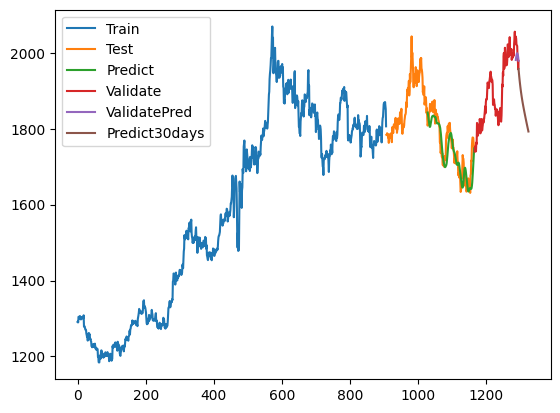

In [ ]:
plt.plot(sc.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,sc.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+121, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,sc.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+121, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
predict_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(predict_data_index,sc.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()

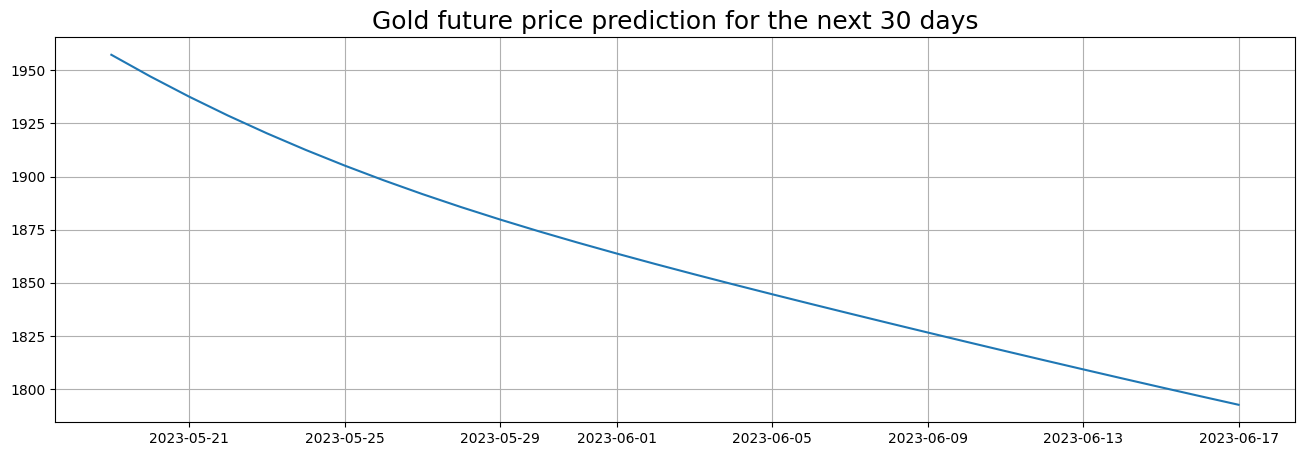

In [ ]:
# Create a dataframe for the future predictions, with the date as the index and the 'price' column
PREDICTIONS_FUTURE = pd.DataFrame(y_pred_future, columns=['price']).set_index(pd.Series(datelist_future))
# Set the figure size and create a subplot
plt.figure(figsize=(16,5))
plt.plot(PREDICTIONS_FUTURE)
# Add a legend and grid
plt.title('Gold future price prediction for the next 30 days',fontsize=18)
plt.grid()

In [ ]:
print(PREDICTIONS_FUTURE)

                  price
2023-05-19  1957.303586
2023-05-20  1947.138426
2023-05-21  1937.617583
2023-05-22  1928.712506
2023-05-23  1920.373166
2023-05-24  1912.551380
2023-05-25  1905.205140
2023-05-26  1898.296502
2023-05-27  1891.786941
2023-05-28  1885.637403
2023-05-29  1879.806093
2023-05-30  1874.251529
2023-05-31  1868.932600
2023-06-01  1863.810677
2023-06-02  1858.850717
2023-06-03  1854.022006
2023-06-04  1849.298262
2023-06-05  1844.658324
2023-06-06  1840.085777
2023-06-07  1835.568010
2023-06-08  1831.096579
2023-06-09  1826.665836
2023-06-10  1822.273196
2023-06-11  1817.917656
2023-06-12  1813.600378
2023-06-13  1809.322574
2023-06-14  1805.087147
2023-06-15  1800.896210
2023-06-16  1796.753085
2023-06-17  1792.659832


In [ ]:
print(test_size, train_size, val_size, look_back)

259 907 130 120
